# Word2vec


### Kerakli kutubxonalar

In [22]:
import re, string
import pandas as pd
from time import time
from collections import defaultdict
import spacy
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
%matplotlib inline
from nltk.stem import SnowballStemmer

### STOP WORDlar

In [9]:
def load_stopwords(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        # Har bir so'zni tozalash va ularni to'plamga joylashtirish
        stopwords = {line.split('\t')[-1].strip() for line in file.readlines()}
    return stopwords

STOPWORDS = load_stopwords('/content/stopwords_unigrams.txt')
print(len(STOPWORDS))

2358


In [10]:
df = pd.read_csv('kunuz_news.csv')

In [11]:
df.head()

,Unnamed: 0,content,target,encoded_text
0,83898,baliqchi tumani eski haqqulobod qishlog‘ining ...,jamiyat,4
1,33159,aqsh prezidenti donald tramp ma’muriyati avval...,jahon,3
2,157963,o‘zbekistonda fuqarolarning mehnat va tadbirko...,o‘zbekiston,5
3,95984,xonanda bahrom nazarov pari pari qo‘shig‘iga y...,jamiyat,4
4,27073,mali shimolida jangarilar harbiy bazalardan bi...,jahon,3


In [41]:
def clean_text(text):
    '''Matnni kichik harflarga o'tkazish, kvadrat qavslar ichidagi matnlarni olib tashlash, tinish belgilarini olib tashlash va raqamlarni o'z ichiga olgan so'zlarni olib tashlash.'''
    text = text.lower()  # Kichik harflarga o'tkazish
    text = re.sub(r'\[.*?\]', '', text)  # Kvadrat qavslar ichidagi matnlarni olib tashlash
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Tinish belgilarini olib tashlash
    text = re.sub(r'\w*\d\w*', '', text)  # Raqamlarni o'z ichiga olgan so'zlarni olib tashlash
    # Faqat bir so'zdan iborat bo'lgan jumlalarni olib tashlash
    if len(text) > 2:
        return ' '.join(word for word in text.split() if word not in STOPWORDS)

df_clean = pd.DataFrame(df.content.apply(lambda x: clean_text(x)))

In [42]:
df_clean.head(15)

,content
0,baliqchi tumani eski haqqulobod qishlog‘ining ...
1,aqsh prezidenti donald tramp ma’muriyati avval...
2,o‘zbekistonda fuqarolarning va tadbirkorlik ta...
3,xonanda bahrom nazarov pari pari qo‘shig‘iga y...
4,mali shimolida jangarilar harbiy bazalardan bi...
5,o‘zbekiston futbol federatsiyasining sobiq pre...
6,o‘zbekiston prezidenti shavkat mirziyoyev o‘n ...
7,merning ma’lum qilishicha afg‘onistonda hokimi...
8,financial times xalqaro ishbilarmonlik gazetas...
9,shahrida havo biroz bulutli bo‘ladi yog‘ingarc...


### Limmitizatsiya

In [43]:
# Oddiy stemm funksiyasi (bu haqiqiy lemmatizatsiya emas, faqat oddiy misol)
def custom_stem(word):
    # O'zbek tilidagi ba'zi oddiy qoidalarni qo'llash
    if word.endswith('lar'):
        return word[:-3]  
    elif word.endswith('da') or word.endswith('da'):
        return word[:-2]  
    elif word.endswith('ni'):
        return word[:-2]  
    return word  # agar hech qanday qoida mos kelmasa, asl so'zni qaytaradi

def lemmatizer(text):
    '''Matnni stemm qilish.'''
    words = text.split()  # Matnni so'zlarga ajratish
    stemmed_words = [custom_stem(word) for word in words]  # Har bir so'zning ildiz shaklini olish
    return " ".join(stemmed_words)  # So'zlarni bo'sh joy bilan ajratib birlashtirish


df_clean["text_lemmatize"] =  df_clean.apply(lambda x: lemmatizer(x['content']), axis=1)

In [44]:
df_clean.head()

,content,text_lemmatize
0,baliqchi tumani eski haqqulobod qishlog‘ining ...,baliqchi tuma eski haqqulobod qishlog‘ining ma...
1,aqsh prezidenti donald tramp ma’muriyati avval...,aqsh prezidenti donald tramp ma’muriyati avval...
2,o‘zbekistonda fuqarolarning va tadbirkorlik ta...,o‘zbekiston fuqarolarning va tadbirkorlik tash...
3,xonanda bahrom nazarov pari pari qo‘shig‘iga y...,xonan bahrom nazarov pari pari qo‘shig‘iga yog...
4,mali shimolida jangarilar harbiy bazalardan bi...,mali shimoli jangari harbiy bazalardan biriga ...


In [45]:
df_clean['text_lemmatize_clean'] = df_clean['text_lemmatize'].str.replace('-PRON-', '')

In [46]:
df_clean.head()

,content,text_lemmatize,text_lemmatize_clean
0,baliqchi tumani eski haqqulobod qishlog‘ining ...,baliqchi tuma eski haqqulobod qishlog‘ining ma...,baliqchi tuma eski haqqulobod qishlog‘ining ma...
1,aqsh prezidenti donald tramp ma’muriyati avval...,aqsh prezidenti donald tramp ma’muriyati avval...,aqsh prezidenti donald tramp ma’muriyati avval...
2,o‘zbekistonda fuqarolarning va tadbirkorlik ta...,o‘zbekiston fuqarolarning va tadbirkorlik tash...,o‘zbekiston fuqarolarning va tadbirkorlik tash...
3,xonanda bahrom nazarov pari pari qo‘shig‘iga y...,xonan bahrom nazarov pari pari qo‘shig‘iga yog...,xonan bahrom nazarov pari pari qo‘shig‘iga yog...
4,mali shimolida jangarilar harbiy bazalardan bi...,mali shimoli jangari harbiy bazalardan biriga ...,mali shimoli jangari harbiy bazalardan biriga ...


In [47]:
sentences = [row.split() for row in df_clean['text_lemmatize_clean']]
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

48966

In [70]:
sorted(word_freq, key=word_freq.get, reverse=True)[:100]

['va',
 'bir',
 'o‘n',
 'yuz',
 'bu',
 'inchi',
 'yigirma',
 'besh',
 'o‘zbekiston',
 'bo‘yicha',
 'to‘rt',
 'to‘qqiz',
 'sakkiz',
 'yetti',
 'u',
 'bo‘lgan',
 'olti',
 'davlat',
 'tomonidan',
 'o‘z',
 'o‘ttiz',
 'ko‘ra',
 'bo‘lib',
 'ham',
 'esa',
 'xabar',
 'tashkil',
 'ushbu',
 'ishlab',
 'amalga',
 'ma’lum',
 'ta',
 'boshqa',
 'eng',
 'shuningdek',
 'yil',
 'ellik',
 'bo‘ladi',
 'etish',
 'qirq',
 'yetmish',
 'orqali',
 'to‘qson',
 'haq',
 'barcha',
 'qabul',
 'olish',
 'oltmish',
 'ta’lim',
 'xalqaro',
 'ish',
 'sakson',
 'ega',
 'rossiya',
 'o‘zi',
 'joriy',
 'viloyati',
 'aqsh',
 'ko‘p',
 'ularning',
 'emas',
 'sifati',
 'yilning',
 'ma’lumot',
 'qilingan',
 'o‘tgan',
 'nol',
 'minus',
 'prezidenti',
 'qayd',
 'hol',
 'ijtimoiy',
 'bo‘lsa',
 'xizmat',
 'davomi',
 'yo‘l',
 'bo‘ldi',
 'holat',
 'mamlakat',
 'oshirish',
 'bo‘lishi',
 'nafar',
 'oliy',
 'milliy',
 'berish',
 'to‘g‘risi',
 'shahri',
 'faoliyati',
 'bergan',
 'tegishli',
 'vaqt',
 'ammo',
 'prezident',
 'bundan',
 'uy

In [95]:
w2v_model = Word2Vec(min_count=50,  # Yoki 10
                     window=10,  # O'zbek tilidagi kontekstni hisobga olish
                     vector_size=200,  # Yoki 300
                     workers=4)  # Yoki 8

In [96]:
w2v_model.build_vocab(sentences)

In [97]:
# matnlarni vektor ko'rinishda train qilish
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs)

(1082538, 2195445)

In [98]:
w2v_model.init_sims(replace=True)

<ipython-input-98-e6ca78b8d40e>:3: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  w2v_model.init_sims(replace=True)


In [107]:
w2v_model.wv.most_similar(positive=['prezident'])

[('mirziyoyev', 0.9424352645874023),
 ('shavkat', 0.9280753135681152),
 ('raisi', 0.8710657358169556),
 ('tashrifi', 0.8666887283325195),
 ('vaziri', 0.8542859554290771),
 ('prezidenti', 0.8523621559143066),
 ('majlisi', 0.8471580743789673),
 ('lavozimiga', 0.8451231718063354),
 ('o‘tdi', 0.8376855850219727),
 ('bag‘ishlangan', 0.8258546590805054)]

In [105]:
w2v_model.wv.similarity('tuman', 'viloyat')

0.9253361

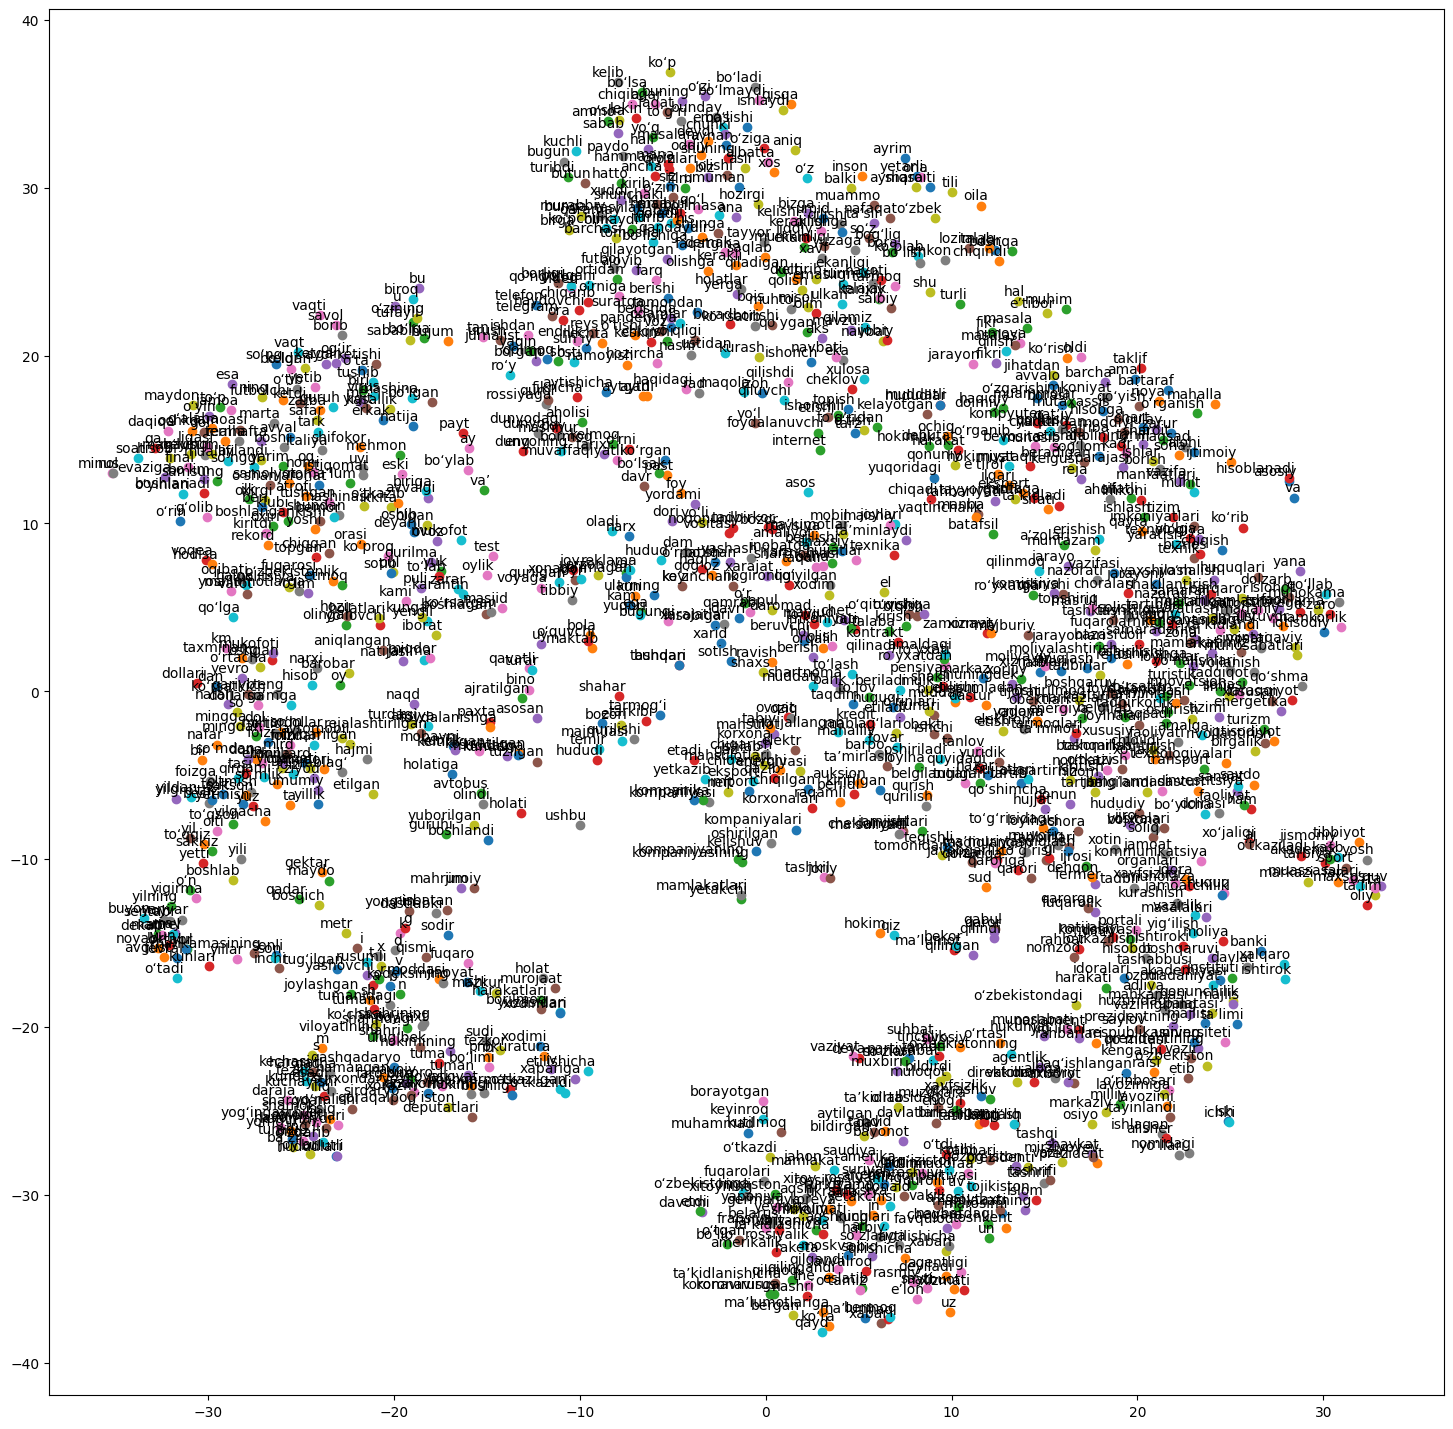

In [106]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def tsne_plot(model):
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    # So'zlar va ularning vektorlarini oling
    for word in model.wv.index_to_key:  # vocab o'rniga index_to_key
        tokens.append(model.wv[word])  # model[word] o'rniga model.wv[word]
        labels.append(word)

    # tokens ro'yxatini numpy massiviga aylantirish
    tokens = np.array(tokens)

    # t-SNE modelini yaratish
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', max_iter=2500, random_state=23)  # n_iter o'rniga max_iter
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(18, 18))
    for i in range(len(x)):
        plt.scatter(x[i], y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

# Modelni t-SNE yordamida tasvirlash
tsne_plot(w2v_model)
